# 第四个数据集：OCD_90_120

来自Dr.SheN贴心的注释：

每次训练的时候，请在上方选择：Kernel-Restart and Run All哦，不然可能出现一些小问题

默认算法：线性回归

默认数据集：PPMI

默认training set：validation set：test set = 8：1：1

默认优化算法：SGD

默认loss：MSELoss（如果是深度方法，由于是二分类问题，建议改成BCE Loss）

这份代码默认实现的是线性回归的训练代码，如果要改成深度方法的代码，要注意outputs = net(inputs)的前向传播的维度和输出。

需要增加的东西：
- K-fold
- 可以尝试PCA降维

## 数据集探索

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = sio.loadmat('OCD_90_200_fMRI.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Sep 15 16:14:34 2021',
 '__version__': '1.0',
 '__globals__': [],
 'NC': array([[[ 1.71912421e+00,  2.21270511e+00,  1.68960500e+00, ...,
           1.33252308e+00,  4.65957680e-01, -6.88871296e-01],
         [ 2.13050475e+00,  2.21960901e+00,  1.29836480e+00, ...,
           2.98712160e-01, -5.18081209e-01, -1.11117704e+00],
         [ 1.08634990e-01,  7.12645125e-01,  1.27033019e+00, ...,
           1.36868045e+00,  1.27166899e+00,  7.43193650e-01],
         ...,
         [ 6.08532543e-01,  6.31457518e-01, -2.19204338e-01, ...,
           1.33883737e+00,  2.30229148e+00,  1.95279573e+00],
         [-2.64155910e-02, -6.53182273e-02, -4.18536691e-02, ...,
           5.92263029e-01,  7.59156459e-01,  4.98339401e-01],
         [-4.85977772e-02,  3.56739070e-02, -1.00098887e-01, ...,
           8.56619253e-01,  1.01913200e+00,  6.93397817e-01]],
 
        [[-1.43473728e+00, -1.83086463e+00, -1.62762613e+00, ...,
    

In [3]:
x_positive = data['NC']
x_negative = data['OCD']
# x_fake_positive = data['EMCI']
# x_fake_negative = data['LMCI']
x_total = np.concatenate((x_positive, x_negative), axis=0).astype(np.float)
y_positive = np.ones(x_positive.shape[0])
# y_fake_positive = np.ones(x_fake_positive.shape[0])
# y_fake_negative = np.zeros(x_negative.shape[0])
y_negative = np.zeros(x_negative.shape[0])
y_total = np.concatenate((y_positive, y_negative), axis=0).astype(np.float)
print('没有加伪样本的时候有{}个正样本，有{}个负样本，一共有{}个样本'.format(y_positive.shape[0], y_negative.shape[0], x_total.shape[0]))
num_x_pos = x_positive.shape[0]
num_x_neg = x_negative.shape[0]
dim_input = np.prod(x_positive.shape[1]**2)
# num_x_fake_pos = x_fake_positive.shape[0]
# num_x_fake_neg = x_fake_negative.shape[0]
# x_total_faked = np.concatenate((x_positive, x_fake_positive, x_fake_negative, x_negative), axis=0).astype(np.float)
# y_total_faked = np.concatenate((y_positive, y_fake_positive, y_fake_negative, y_negative), axis=0).astype(np.float)
# num_fake_total = x_total_faked.shape[0]
num_total = x_total.shape[0]
# print('加了伪样本之后有{}个正样本，有{}个负样本，一共有{}个样本'.format(num_x_fake_pos+num_x_pos, num_x_fake_neg+num_x_neg, num_fake_total))
print(x_positive.shape, x_negative.shape, x_total.shape, y_positive.shape, num_x_neg, num_x_pos, dim_input)

没有加伪样本的时候有20个正样本，有62个负样本，一共有82个样本
(20, 90, 200) (62, 90, 200) (82, 90, 200) (20,) 62 20 8100


In [4]:
# x_total_faked

## 利用TSNE和PCA的可视化，发现几乎不具有线性可分性

In [5]:
x_tsne = TSNE(n_components=2).fit_transform(x_total.reshape(num_total, -1))
print(x_tsne.shape)

(82, 2)


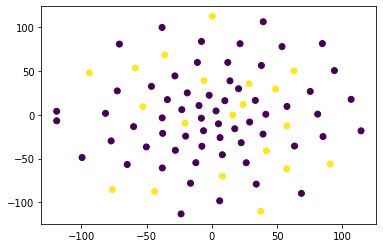

In [6]:
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c = list(y_total))

In [7]:
x_pca = PCA(n_components=2).fit_transform(x_total.reshape(num_total, -1))
print(x_pca.shape)

(82, 2)


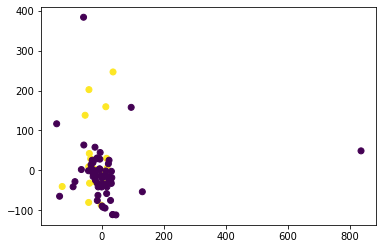

In [8]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c = list(y_total))

## 数据预处理（划分train/test dataset和载入dataloader）

### 数据预处理第一步，计算相关系数，并flatten

In [9]:
import torch
def corrcoef(input):
    """传入一个tensor格式的矩阵x(x.shape(m,n))，输出其相关系数矩阵"""
    output = []
    for index, x in enumerate(input):
        f = (x.shape[0] - 1) / x.shape[0]      # 方差调整系数
        x_reducemean = x - np.mean(x, axis=0)
        numerator = np.matmul(x_reducemean.T, x_reducemean) / x.shape[0]
        var_ = x.var(axis=0).reshape(x.shape[1], 1)
        denominator = np.sqrt(np.matmul(var_, var_.T)) * f
        output.append(numerator / denominator)
    return output
# print(x_total[:, :, 19:179].shape)
pearson = corrcoef(x_total[:, :, 20:180].reshape(82, 160, 90))
pearson = np.array(pearson)
pearson_cutted = np.zeros((82, 45*89))
dim_pearson = 90
t = 0
for k in range(pearson.shape[0]):
    for i in range(dim_pearson):
        for j in range(dim_pearson):
            if i < j:
                pearson_cutted[k, t] = pearson[k, i, j]
                t = t + 1
        
    t = 0
pearson_cutted = np.array(pearson_cutted)
print(pearson_cutted.shape)

(82, 4005)


### 数据预处理第二步，划分t/t dataset和载入dataloader

In [10]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import random
random.seed(1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
################# batch_size也是一个超参数，第一个调整的参数就是batch_size,可选：1，2，4，8，16，32。
batch_size = 1
kfold = 10
dim_input = 4005

meta_size = int(0.1*x_total.shape[0])
# train_size = int(0.8*x_total.shape[0])
# test_size = int(0.9*x_total.shape[0])
x_total = pearson_cutted
# x_train = []
# y_train = []
# x_val = []
# y_val = []
# x_test = []
# y_test = []
# for i in range(kfold):
#     x_train.append(mixed[meta_size * i: meta_size * (i+1), :dim_input])
    

# x_total = pearson_cutted
# mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
# random.shuffle(mixed)


# print(mixed)
# x_train = mixed[:train_size, :dim_input]
# y_train = mixed[:train_size, dim_input:]
# print(x_train.shape, y_train.shape)
# x_val = mixed[train_size:test_size, :dim_input]
# y_val = mixed[train_size:test_size, dim_input:]
# print(x_val.shape, y_val.shape)
# x_test = mixed[test_size:, :dim_input]
# y_test = mixed[test_size:, dim_input:]
# print(x_test.shape, y_test.shape)

# transform = transforms.Compose([
#     transforms.Normalize(0.5, 0.5)
# ])
# train_data = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
# # print(train_data[0][0].dtype)
# val_data = Data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
# test_data = Data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
# train_loader = Data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
# val_loader = Data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=1)
# test_loader = Data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=True, num_workers=1)
# total_loader = Data.DataLoader(dataset = Data.TensorDataset(torch.Tensor(mixed[:,:dim_input]), torch.Tensor(mixed[:, dim_input:])), batch_size = batch_size, shuffle=True, num_workers=1)
# print(len(train_data), len(val_data), len(test_data))

下面只需要用train_loader作为迭代器，用x_val,y_val（迭代器val_loader）来调参，当在x_val和y_val上达到最优的时候，在x_test(test_loader)上测试一次，作为一个算法的最终结果

In [11]:
# ########### 用于eval，非必要不改动
# ########### 敏感性即召回率，true positive rate = TP/(TP+FN)
# ########### 特异度为true negative rate = TN/(FP+TN)
# def evaluate_accuracy(loader, net):
#     net.eval()
#     sum_all = 0
#     sum_acc = 0
#     FN = 0
#     TN = 0
#     TP = 0
#     FP = 0
    
#     for index, (data, label) in enumerate(loader):
#         with torch.no_grad():
#             data = Variable(data, requires_grad=True).to(device)
#             label = Variable(label, requires_grad=True).to(device)
#         outputs = (net(data) > 0.5).type(torch.float)
# #         print(outputs.shape, label.shape)
#         sum_acc += torch.sum(outputs.argmax(0) == label)
#         for i in range(outputs.shape[0]):
#             if outputs[i, 0] == label[i] and label[i] == 1:
#                 TP += 1
#             elif outputs[i, 0] == label[i] and label[i] == 0:
#                 TN += 1
#             elif outputs[i, 0] != label[i] and label[i] == 1:
#                 FN += 1
#             else:
#                 FP += 1
#         sum_all += data.shape[0]
#     print('total validation set data:{}, numbers of accurately labeled data:{}'.format(sum_all, sum_acc.detach()))
#     acc = sum_acc / sum_all
#     net.train()
#     if (TP + FN) == 0:
#         sensitivity = 0
#     else:
#         sensitivity = TP / (TP + FN)
#     if (FP + TN) == 0:
#         specificity = 0
#     else:
#         specificity = TN / (FP + TN)
#     return acc, sensitivity, specificity

## 实现算法一（传统方法）

In [12]:
# ##############在class里面定义自己的算法，xxxx是算法的名字。
# class xxxx(nn.Module):
#     def __init__(self, n_feature):
#         super(xxxx, self).__init__()
#         self.linear = nn.Linear(n_feature, 1)
    
#         self.init_weights()

#     def init_weights(self):
#         """Xavier initialization for the fully connected layer
#         """
#         self.linear.weight.data.uniform_(-1, 1)
#         self.linear.bias.data.fill_(0)

#     def forward(self, x):
#         y = self.linear(x)
#         return torch.sigmoid(y)
    
# # net = LinearNet(dim_input).to(device)
# # print(net) # 使用print可以打印出网络的结构

### SVM的evaluate代码

In [13]:
# def evaluate_svm(x_val, net):
#     score = clf.score(x_val, y_val)
#     pred = clf.predict(x_val)
#     FN = 0
#     TN = 0
#     TP = 0
#     FP = 0
# #     sum_acc += np.sum(clf.predict(x_val) == y_val.reshape(x_val.shape[0]))
#     for i in range(pred.shape[0]):
#         if pred[i] == y_val[i, 0] and y_val[i, 0] == 1:
#             TP += 1
#         elif pred[i] == y_val[i, 0] and y_val[i, 0] == 0:
#             TN += 1
#         elif pred[i] != y_val[i, 0] and y_val[i, 0] == 1:
#             FN += 1
#         else:
#             FP += 1
#     if (TP + FN) == 0:
#         sensitivity = 0
#     else:
#         sensitivity = TP / (TP + FN)
#     if (FP + TN) == 0:
#         specificity = 0
#     else:
#         specificity = TN / (FP + TN)
        
#     return score, sensitivity, specificity

### SVM训练过程代码

In [14]:
# import time
# from sklearn.metrics import roc_curve, auc, roc_auc_score
# import sklearn.metrics as metrics
# # var_list = [0.1, 0.5, 1, 1.5, 5, 10]
# var_list = ['rbf','linear', 'poly', 'sigmoid']
# for var in var_list:
#     avg_sen = 0
#     avg_spe = 0
#     avg_score = 0
#     roc_auc = dict()
#     fpr = dict()
#     tpr = dict()
#     print('var of SVM:{}'.format(var))
#     for j in range(100):
#         random.seed(j+1)
#         mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
#         random.shuffle(mixed)
#         kfold = 10
#         GTlist = None
#         Problist = None
#     #     scores = []
#     #     avg_score = 0
#         for i in range(kfold):
#             clf = SVC(kernel = var, probability = True)
#             x_val = mixed[meta_size * i:meta_size*(i+1), :dim_input]
#             y_val = mixed[meta_size * i:meta_size*(i+1), dim_input:]
#             x_train = np.concatenate((mixed[:meta_size*i, :dim_input], mixed[meta_size*(i+1):, :dim_input]), axis=0)
#             y_train = np.concatenate((mixed[:meta_size*i, dim_input:], mixed[meta_size*(i+1):, dim_input:]), axis=0)
#             clf.fit(x_train, y_train)
#         #     print('predict:{}, true:{}'.format(clf.predict(x_val), y_val))

#             score, sen, spe = evaluate_svm(x_val, clf)
#     #         score = clf.score(x_val, y_val)
#     #         scores.append(score)
#             avg_score += score
#             avg_spe += spe
#             avg_sen += sen
#             if j is 1:
#                 if GTlist is None:
#                     GTlist = y_val
#                 else:
#                     GTlist = np.concatenate((GTlist, y_val), axis = 0)
#                 if Problist is None:
#                     Problist = clf.predict(x_val)
#                 else:
#                     Problist = np.concatenate((Problist, clf.predict_proba(x_val)[:, 1]), axis = 0)
#         if j is 1:
# #             print(GTlist.shape, Problist.shape)
#             fpr, tpr, thresholds = metrics.roc_curve(GTlist.reshape(80), Problist, pos_label=1)
# #             print(fpr.shape)
#             roc_auc = metrics.auc(fpr, tpr)  #auc为Roc曲线下的面积
#             print(roc_auc_score(GTlist, Problist))


#             plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
#             plt.legend(loc='lower right')
#             # plt.plot([0, 1], [0, 1], 'r--')
#             plt.xlim([-0.1, 1.1])
#             plt.ylim([-0.1, 1.1])
#             plt.xlabel('False Positive Rate') #横坐标是fpr
#             plt.ylabel('True Positive Rate')  #纵坐标是tpr
#             plt.title('Receiver operating characteristic example')
#             plt.savefig('roc_curve.png')
#             plt.show()
#     #         fpr, tpr, _ = roc_curve(y_val, clf.predict(x_val), pos_label=2)
#     #         roc_auc = auc(fpr, tpr)
#         #     print(scores)
#     print('score:{}'.format(avg_score/(kfold * 100)))
#     print('specificity:{}'.format(avg_spe/(kfold*100)))
#     print('sensitivity:{}'.format(avg_sen/(kfold*100)))
#     print(clf.predict(x_val), y_val)
#     print('\n')

In [15]:
# print(clf.predict(x_val), np.sum(clf.predict(x_val) == y_val.reshape(x_val.shape[0])))
# print(y_val[2, 0])

## 实现算法二（传统方法/深度方法）

In [25]:
# ##############在class里面定义自己的算法，xxxx是算法的名字。
# ### GAN based-methods
# ########### 用于eval，非必要不改动
# ########### 敏感性即召回率，true positive rate = TP/(TP+FN)
# ########### 特异度为true negative rate = TN/(FP+TN)
import torch.nn.functional as F
def evaluate_accuracy(loader, net):
    net.eval()
    sum_all = 0
    sum_acc = 0
    FN = 0
    TN = 0
    TP = 0
    FP = 0
    
    for index, (data, label) in enumerate(loader):
        with torch.no_grad():
            data = Variable(data, requires_grad=False).to(device)
            label = Variable(label, requires_grad=False).to(device)
        outputs = net(data).argmax(1).reshape(data.shape[0])
#         print(outputs.shape, label.shape)
        sum_acc += torch.sum(outputs == label.reshape(data.shape[0]))
        label = label.reshape(data.shape[0])
        for i in range(outputs.shape[0]):
            if outputs[i] == label[i] and label[i] == 1:
                TP += 1
            elif outputs[i] == label[i] and label[i] == 0:
                TN += 1
            elif outputs[i] != label[i] and label[i] == 1:
                FN += 1
            else:
                FP += 1
        sum_all += data.shape[0]
#     print('\t\t\ttotal validation set data:{}, numbers of accurately labeled data:{}'.format(sum_all, sum_acc.detach()))
    acc = sum_acc / sum_all
    net.train()
    if (TP + FN) == 0:
        sensitivity = 0
    else:
        sensitivity = TP / (TP + FN)
    if (FP + TN) == 0:
        specificity = 0
    else:
        specificity = TN / (FP + TN)
    return acc, sensitivity, specificity
class generator(nn.Module):
    def __init__(self,n_input, n_feature):
        super(generator, self)
        self.linear1 = nn.Linear(n_input, n_features[0])
        self.linear2 = nn.Linear(n_features[0], n_features[1])
        self.linear3 = nn.Linear(n_features[1], 4095)
    def forward(x):
        x = nn.LeakyReLU(self.linear1(x), inplace=True)
        x = nn.LeakyReLU(self.linear2(x), inplace=True)
        x = self.linear3(x)
        return x
class MLP(nn.Module):
    def __init__(self, n_feature):
        super(MLP, self).__init__()
#         nn.conv1 = 
#         resnet18 = models.resnet18(pretrained=True)
#         resnet18.fc = nn.Linear(512, 2)
        self.linear1 = nn.Linear(n_feature, 1000)
        self.linear3 = nn.Linear(1000, 100)
#         self.linear4 = resnet18.fc
        self.linear4 = nn.Linear(100, 2)
        self.init_weights()

    def init_weights(self):
        """Xavier initialization for the fully connected layer
        """
        self.linear1.weight.data.uniform_(-1, 1)
        self.linear1.bias.data.fill_(0)
#         self.linear2.weight.data.uniform_(-1, 1)
#         self.linear2.bias.data.fill_(0)
        self.linear3.weight.data.uniform_(-1, 1)
        self.linear3.bias.data.fill_(0)
        self.linear4.weight.data.uniform_(-1, 1)
        self.linear4.bias.data.fill_(0)

    def forward(self, x):
        out = F.dropout(F.relu((self.linear1(x))))
        out = F.dropout(F.relu(self.linear3(out)))
        out = self.linear4(out)
#         x = self.linear4(x)
        return out
    
# # net = LinearNet(dim_input).to(device)
# # print(net) # 使用print可以打印出网络的结构

In [26]:
# #########  训练过程，可以不动它
# class LabelSmoothSoftmaxCEV1(nn.Module):
#     '''
#     This is the autograd version, you can also try the LabelSmoothSoftmaxCEV2 that uses derived gradients
#     '''

#     def __init__(self, lb_smooth=0.1, reduction='mean', ignore_index=-100):
#         super(LabelSmoothSoftmaxCEV1, self).__init__()
#         self.lb_smooth = lb_smooth
#         self.reduction = reduction
#         self.lb_ignore = ignore_index
#         self.log_softmax = nn.LogSoftmax(dim=1)

#     def forward(self, logits, label):
#         '''
#         Same usage method as nn.CrossEntropyLoss:
#             >>> criteria = LabelSmoothSoftmaxCEV1()
#             >>> logits = torch.randn(8, 19, 384, 384) # nchw, float/half
#             >>> lbs = torch.randint(0, 19, (8, 384, 384)) # nhw, int64_t
#             >>> loss = criteria(logits, lbs)
#         '''
#         # overcome ignored label
#         logits = logits.float() # use fp32 to avoid nan
#         with torch.no_grad():
#             num_classes = logits.size(1)
#             label = label.clone().detach()
#             ignore = label.eq(self.lb_ignore)
#             n_valid = ignore.eq(0).sum()
#             label[ignore] = 0
#             lb_pos, lb_neg = 1. - self.lb_smooth, self.lb_smooth / num_classes
#             lb_one_hot = torch.empty_like(logits).fill_(
#                 lb_neg).scatter_(1, label.unsqueeze(1), lb_pos).detach()

#         logs = self.log_softmax(logits)
#         loss = -torch.sum(logs * lb_one_hot, dim=1)
#         loss[ignore] = 0
#         if self.reduction == 'mean':
#             loss = loss.sum() / n_valid
#         if self.reduction == 'sum':
#             loss = loss.sum()

#         return loss


# losses = []
# accuracy = []
# sensitivity = []
# specificity = []
# preds = []
# labels = []
# avg_accuracy = []
# print_every = 100
# print_loss_total = 0
# for seed in range(1):
#     random.seed(seed)
#     mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
#     random.shuffle(mixed)
#     kfold = 10
#     GTlist = None
#     Problist = None
#     for i in range(kfold):
#         num_epochs = 10 # 训练的epoch
#         dim_input = 4005
#         ######### 实例化算法对象
#         xx = MLP(dim_input).to(device)
#         ######### 选择损失函数MSELoss
#         criterion = LabelSmoothSoftmaxCEV1().to(device)
#         ########### 选择minibatch SGD算法
#         learning_rate = 0.001
#         ########## 这里面的xxxx是算法对象的实例化，我们的优化算法固定为SGD，可选momentum和nesterov，lr为超参数需要调优
#         optimizer = optim.Adam(xx.parameters(), lr=learning_rate)
#         print('fold:{}'.format(i))
#         x_val = mixed[meta_size * i:meta_size*(i+1), :dim_input]
#         y_val = mixed[meta_size * i:meta_size*(i+1), dim_input:]
#         x_train = np.concatenate((mixed[:meta_size*i, :dim_input], mixed[meta_size*(i+1):, :dim_input]), axis=0)
#         y_train = np.concatenate((mixed[:meta_size*i, dim_input:], mixed[meta_size*(i+1):, dim_input:]), axis=0)
#         train_data = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
#         # print(train_data[0][0].dtype)
#         val_data = Data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
#     #     test_data = Data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
#         train_loader = Data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
#         val_loader = Data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=1)
#     #     test_loader = Data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=True, num_workers=1)

#         for epoch in range(num_epochs):
#             xx.train()
# #             print('\tEpoch:{}'.format(epoch+1))
#             for index, (data1, label1) in enumerate(train_loader):
#                 data = Variable(data1, requires_grad=True).to(device)
#                 label = Variable(label1, requires_grad=True).to(device)
#                 output = xx(data)
# #                 print(output.shape, label.shape)
# #                 label = label.squeeze()
#         #         label = label.squeeze()
#                 loss = criterion(output, label.detach().reshape(label.shape[0]).long())

#                 print_loss_total += loss

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 for i in range(data.shape[0]):
#                     preds.append(output[i, int(np.array(label[i].detach().cpu())[0])].detach().cpu())
#                     labels.append(label[i].detach().cpu())
#                 if index % print_every == 0:
#                     print_loss_avg = print_loss_total / print_every
#                     print('\t\tloss:{}'.format(print_loss_avg))
#                     losses.append(print_loss_avg)
#                     print_loss_total = 0
#             acc, sen, spe = evaluate_accuracy(val_loader, xx)
#             accuracy.append(acc)
#             sensitivity.append(sen)
#             specificity.append(spe)
# #             if epoch % 10 == 0:
#             print('\tEpoch:{}, Accuracy:{}, Sensitivity:{}, Specificity:{}'.format(epoch+1, acc, sen, spe))
#             print('\n')
#             tacc, _, _ = evaluate_accuracy(train_loader, xx)
#             print('training accuracy:{}'.format(tacc))
#         acc, sen, spe = evaluate_accuracy(val_loader, xx)
#         avg_accuracy.append(acc)
#     mean_accuracy = 0
#     for i in avg_accuracy:
#         mean_accuracy += i
#     print('average_accuracy:{}'.format(mean_accuracy / kfold))
# total_loader = Data.DataLoader(dataset = Data.TensorDataset(torch.Tensor(mixed[:,:dim_input]), torch.Tensor(mixed[:, dim_input:])), batch_size = batch_size, shuffle=True, num_workers=1)
# tmp, _, _ = evaluate_accuracy(total_loader, xx)
# print('total acc:', tmp)
# tmp, _, _ = evaluate_accuracy(total_loader, xx)
# print('total acc:', tmp)
# avg_sen = 0
# avg_spe = 0
# for i, (sen, spe) in enumerate(zip(sensitivity, specificity)):
#     avg_sen += sen
#     avg_spe += spe 
# print('sensitivity:{}, specificity:{}'.format(avg_sen / len(sensitivity), avg_spe / len(specificity)))

## 实现算法三（深度方法）

In [31]:
import learn2learn as l2l
#########  训练过程，可以不动它
import torch.nn.functional as F
def evaluate_accuracy(loader, net):
    net.eval()
    sum_all = 0
    sum_acc = 0
    FN = 0
    TN = 0
    TP = 0
    FP = 0
    
    for index, (data, label) in enumerate(loader):
        with torch.no_grad():
            data = Variable(data, requires_grad=False).to(device)
            label = Variable(label, requires_grad=False).to(device)
        outputs = net(data).argmax(1).reshape(data.shape[0])
#         print(outputs.shape, label.shape)
        sum_acc += torch.sum(outputs == label.reshape(data.shape[0]))
        label = label.reshape(data.shape[0])
        for i in range(outputs.shape[0]):
            if outputs[i] == label[i] and label[i] == 1:
                TP += 1
            elif outputs[i] == label[i] and label[i] == 0:
                TN += 1
            elif outputs[i] != label[i] and label[i] == 1:
                FN += 1
            else:
                FP += 1
        sum_all += data.shape[0]
#     print('\t\t\ttotal validation set data:{}, numbers of accurately labeled data:{}'.format(sum_all, sum_acc.detach()))
    acc = sum_acc / sum_all
    net.train()
    if (TP + FN) == 0:
        sensitivity = 0
    else:
        sensitivity = TP / (TP + FN)
    if (FP + TN) == 0:
        specificity = 0
    else:
        specificity = TN / (FP + TN)
    return acc, sensitivity, specificity
class generator(nn.Module):
    def __init__(self,n_input, n_feature):
        super(generator, self)
        self.linear1 = nn.Linear(n_input, n_features[0])
        self.linear2 = nn.Linear(n_features[0], n_features[1])
        self.linear3 = nn.Linear(n_features[1], 4095)
    def forward(x):
        x = nn.LeakyReLU(self.linear1(x), inplace=True)
        x = nn.LeakyReLU(self.linear2(x), inplace=True)
        x = self.linear3(x)
        return x
class MLP(nn.Module):
    def __init__(self, n_feature):
        super(MLP, self).__init__()
#         nn.conv1 = 
#         resnet18 = models.resnet18(pretrained=True)
#         resnet18.fc = nn.Linear(512, 2)
        self.linear1 = nn.Linear(n_feature, 1000)
        self.linear3 = nn.Linear(1000, 100)
#         self.linear4 = resnet18.fc
        self.linear4 = nn.Linear(100, 2)
        self.init_weights()

    def init_weights(self):
        """Xavier initialization for the fully connected layer
        """
        self.linear1.weight.data.uniform_(-1, 1)
        self.linear1.bias.data.fill_(0)
#         self.linear2.weight.data.uniform_(-1, 1)
#         self.linear2.bias.data.fill_(0)
        self.linear3.weight.data.uniform_(-1, 1)
        self.linear3.bias.data.fill_(0)
        self.linear4.weight.data.uniform_(-1, 1)
        self.linear4.bias.data.fill_(0)

    def forward(self, x):
        out = F.dropout(F.relu((self.linear1(x))))
        out = F.dropout(F.relu(self.linear3(out)))
        out = self.linear4(out)
#         x = self.linear4(x)
        return out

losses = []
accuracy = []
sensitivity = []
specificity = []
preds = []
labels = []
avg_accuracy = []
print_every = 100
print_loss_total = 0
for seed in range(1):
    random.seed(seed)
    mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
    random.shuffle(mixed)
    kfold = 10
    GTlist = None
    Problist = None
    for i in range(kfold):
        num_epochs = 10 # 训练的epoch
        dim_input = 4005
        ######### 实例化算法对象
        xx = MLP(dim_input).to(device)
        learning_rate = 0.001
        learning_rate_maml = 0.001
        xx = l2l.algorithms.MAML(xx, lr = learning_rate_maml).to(device)
        ######### 选择损失函数MSELoss
        criterion = nn.CrossEntropyLoss().to(device)
        ########### 选择minibatch SGD算法
        ########## 这里面的xxxx是算法对象的实例化，我们的优化算法固定为SGD，可选momentum和nesterov，lr为超参数需要调优
        optimizer = optim.Adam(xx.parameters(), lr=learning_rate)
        print('fold:{}'.format(i))
        x_val = mixed[meta_size * i:meta_size*(i+1), :dim_input]
        y_val = mixed[meta_size * i:meta_size*(i+1), dim_input:]
        x_train = np.concatenate((mixed[:meta_size*i, :dim_input], mixed[meta_size*(i+1):, :dim_input]), axis=0)
        y_train = np.concatenate((mixed[:meta_size*i, dim_input:], mixed[meta_size*(i+1):, dim_input:]), axis=0)
        train_data = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
        val_data = Data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
        train_data = l2l.data.MetaDataset(train_data)
        val_data = l2l.data.MetaDataset(val_data)
    #     test_data = Data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
        train_loader = Data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
        val_loader = Data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=1)
    #     test_loader = Data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=True, num_workers=1)

        for epoch in range(num_epochs):
            xx.train()
#             print('\tEpoch:{}'.format(epoch+1))
            for index, (data1, label1) in enumerate(train_loader):
                optimizer.zero_grad()    
                data = Variable(data1, requires_grad=True).to(device)
                label = Variable(label1, requires_grad=True).to(device)
                clone_model = xx.clone()
                error = criterion(clone_model(data), label.detach().reshape(label.shape[0]).long())
                clone_model.adapt(error)
#                 print(output.shape, label.shape)
#                 label = label.squeeze()
        #         label = label.squeeze()
                output = clone_model(data)
                loss = criterion(output, label.detach().reshape(label.shape[0]).long())

                print_loss_total += loss

                loss.backward()
                optimizer.step()
                for i in range(data.shape[0]):
                    preds.append(output[i, int(np.array(label[i].detach().cpu())[0])].detach().cpu())
                    labels.append(label[i].detach().cpu())
                if index % print_every == 0:
                    print_loss_avg = print_loss_total / print_every
                    print('\t\tloss:{}'.format(print_loss_avg))
                    losses.append(print_loss_avg)
                    print_loss_total = 0
            acc, sen, spe = evaluate_accuracy(val_loader, xx)
            accuracy.append(acc)
            sensitivity.append(sen)
            specificity.append(spe)
#             if epoch % 10 == 0:
            print('\tEpoch:{}, Accuracy:{}, Sensitivity:{}, Specificity:{}'.format(epoch+1, acc, sen, spe))
            print('\n')
            tacc, _, _ = evaluate_accuracy(train_loader, xx)
            print('training accuracy:{}'.format(tacc))
        acc, sen, spe = evaluate_accuracy(val_loader, xx)
        avg_accuracy.append(acc)
    mean_accuracy = 0
    for i in avg_accuracy:
        mean_accuracy += i
    print('average_accuracy:{}'.format(mean_accuracy / kfold))
total_loader = Data.DataLoader(dataset = Data.TensorDataset(torch.Tensor(mixed[:,:dim_input]), torch.Tensor(mixed[:, dim_input:])), batch_size = batch_size, shuffle=True, num_workers=1)
tmp, _, _ = evaluate_accuracy(total_loader, xx)
print('total acc:', tmp)
tmp, _, _ = evaluate_accuracy(total_loader, xx)
print('total acc:', tmp)
avg_sen = 0
avg_spe = 0
for i, (sen, spe) in enumerate(zip(sensitivity, specificity)):
    avg_sen += sen
    avg_spe += spe 
print('sensitivity:{}, specificity:{}'.format(avg_sen / len(sensitivity), avg_spe / len(specificity)))

fold:0
		loss:0.0
	Epoch:1, Accuracy:0.125, Sensitivity:0.125, Specificity:0


training accuracy:0.5675675868988037
		loss:115.45267486572266
	Epoch:2, Accuracy:0.5, Sensitivity:0.5, Specificity:0


training accuracy:0.5270270109176636
		loss:98.05325317382812
	Epoch:3, Accuracy:0.5, Sensitivity:0.5, Specificity:0


training accuracy:0.6081081032752991
		loss:79.45931243896484
	Epoch:4, Accuracy:0.875, Sensitivity:0.875, Specificity:0


training accuracy:0.6756756901741028
		loss:118.14140319824219
	Epoch:5, Accuracy:0.5, Sensitivity:0.5, Specificity:0


training accuracy:0.7297297716140747
		loss:150.459228515625
	Epoch:6, Accuracy:0.75, Sensitivity:0.75, Specificity:0


training accuracy:0.7837837934494019
		loss:78.45235443115234
	Epoch:7, Accuracy:0.25, Sensitivity:0.25, Specificity:0


training accuracy:0.7972972989082336
		loss:32.44796371459961
	Epoch:8, Accuracy:0.75, Sensitivity:0.75, Specificity:0


training accuracy:0.824324369430542
		loss:73.6486587524414
	Epoch:9, Accurac

training accuracy:0.7432432770729065
		loss:110.44136810302734
	Epoch:6, Accuracy:0.625, Sensitivity:1.0, Specificity:0.5714285714285714


training accuracy:0.8108108043670654
		loss:119.70387268066406
	Epoch:7, Accuracy:0.75, Sensitivity:0.0, Specificity:0.8571428571428571


training accuracy:0.7702702879905701
		loss:94.90531158447266
	Epoch:8, Accuracy:0.5, Sensitivity:1.0, Specificity:0.42857142857142855


training accuracy:0.7972972989082336
		loss:38.18915557861328
	Epoch:9, Accuracy:1.0, Sensitivity:1.0, Specificity:1.0


training accuracy:0.9189189672470093
		loss:51.06658172607422
	Epoch:10, Accuracy:0.5, Sensitivity:1.0, Specificity:0.42857142857142855


training accuracy:0.7702702879905701
fold:7
		loss:35.374046325683594
	Epoch:1, Accuracy:0.5, Sensitivity:0.0, Specificity:0.6666666666666666


training accuracy:0.6351351737976074
		loss:81.77010345458984
	Epoch:2, Accuracy:0.625, Sensitivity:0.5, Specificity:0.6666666666666666


training accuracy:0.5675675868988037
		loss:1

## 具体训练代码

In [ ]:
# #########  训练过程，可以不动它
# mixed = np.concatenate((x_total, y_total.reshape((-1, 1))), axis = 1)
# losses = []
# accuracy = []
# sensitivity = []
# specificity = []
# preds = []
# labels = []
# avg_accuracy = []
# print_every = 30
# print_loss_total = 0

# total_loader = Data.DataLoader(dataset = Data.TensorDataset(torch.Tensor(mixed[:,:dim_input]), torch.Tensor(mixed[:, dim_input:])), batch_size = batch_size, shuffle=True, num_workers=1)
# for i in range(kfold):
#     print('fold:{}'.format(i))
#     x_val = mixed[meta_size * i:meta_size*(i+1), :dim_input]
#     y_val = mixed[meta_size * i:meta_size*(i+1), dim_input:]
#     x_train = np.concatenate((mixed[:meta_size*i, :dim_input], mixed[meta_size*(i+1):, :dim_input]), axis=0)
#     y_train = np.concatenate((mixed[:meta_size*i, dim_input:], mixed[meta_size*(i+1):, dim_input:]), axis=0)
#     train_data = Data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
#     # print(train_data[0][0].dtype)
#     val_data = Data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
# #     test_data = Data.TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
#     train_loader = Data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=1)
#     val_loader = Data.DataLoader(dataset = val_data, batch_size = batch_size, shuffle=True, num_workers=1)
# #     test_loader = Data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=True, num_workers=1)

#     for epoch in range(num_epochs):
#         xx.train()
#         print('\tEpoch:{}'.format(epoch+1))
#         for index, (data1, label1) in enumerate(train_loader):
#             data = Variable(data1, requires_grad=True).to(device)
#             label = Variable(label1, requires_grad=True).to(device)
#             output = xx(data)
#     #         label = label.squeeze()
#             loss = criterion(output, label.detach())

#             print_loss_total += loss

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             for i in range(data.shape[0]):
#                 preds.append(output[i].detach().cpu())
#                 labels.append(label[i].detach().cpu())
#             if index % print_every == 0:
#                 print_loss_avg = print_loss_total / print_every
#                 print('\t\tloss:{}'.format(print_loss_avg))
#                 losses.append(print_loss_avg)
#                 print_loss_total = 0
#         acc, sen, spe = evaluate_accuracy(val_loader, xx)
#         accuracy.append(acc)
#         sensitivity.append(sen)
#         specificity.append(spe)
#         print('\tEpoch:{}, Accuracy:{}, Sensitivity:{}, Specificity:{}'.format(epoch+1, acc, sen, spe))
#         print('\n')
#     acc, sen, spe = evaluate_accuracy(val_loader, xx)
#     avg_accuracy.append(acc)
# mean_accuracy = 0
# for i in avg_accuracy:
#     mean_accuracy += i
# print('average_accuracy:{}'.format(mean_accuracy / kfold))

In [ ]:
print(avg_accuracy)

## 可视化

In [ ]:
plt_list = [losses, accuracy, sensitivity, specificity]
plt.figure(figsize = (10, 10))
for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.plot(plt_list[i])

## ROC曲线可视化


ROC曲线下的面积为AUC，这个面积（下面打印的结果）如果大于0.5就证明具有一定价值，越接近1越好。如果实验完全随机，那么面积就等于0.5，就相当于p用没有

0.5269146858301087


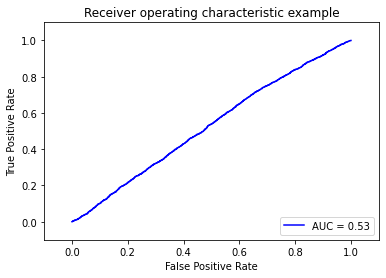

In [28]:
# coding=UTF-8
from sklearn import metrics
import matplotlib.pylab as pylab

# 这个GTlist是真实标签
GTlist = labels
# 这个是预测值，
Problist = preds



## 下面的不要改变
fpr, tpr, thresholds = metrics.roc_curve(GTlist, Problist, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)  #auc为Roc曲线下的面积
print(roc_auc)

pylab.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
pylab.legend(loc='lower right')
# plt.plot([0, 1], [0, 1], 'r--')
pylab.xlim([-0.1, 1.1])
pylab.ylim([-0.1, 1.1])
pylab.xlabel('False Positive Rate') #横坐标是fpr
pylab.ylabel('True Positive Rate')  #纵坐标是tpr
pylab.title('Receiver operating characteristic example')
pylab.show()

## 当所有超参数调整好的时候，在测试集上运行一次，作为最终的accuracy，请记录下来

In [ ]:
acc, sen, spe = evaluate_accuracy(test_loader, xx)
print('Accuracy on test set:{}, \tSensitivity on test set:{}, \tSpecificity on test set:{}'.format(acc, sen, spe))

In [ ]:
acc, sen, spe = evaluate_accuracy(total_loader, xx)
print('Accuracy on total set:{}, \tSensitivity on test set:{}, \tSpecificity on test set:{}'.format(acc, sen, spe))

In [ ]:
# ################################### test
# # clf = SVC(kernel='linear')
# # clf.fit(x_total, y_total)
# # pred = clf.predict(x_total)
# print(np.sum(preds==labels))
# # print(f"Classification report for classifier {xx>0.5}:\n"
# #       f"{metrics.classification_report(labels, preds)}\n")
# disp = metrics.plot_confusion_matrix(xx, x_train, y_train)
# disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")

# plt.show()

# ADNI

In [ ]:
data_adni = sio.loadmat('ADNI.mat')
x_positive = data_adni['NC']
x_negative = data_adni['AD']
x_total = np.concatenate((x_positive, x_negative), axis=0).astype(np.float)
y_positive = np.ones(x_positive.shape[0])
y_negative = np.zeros(x_negative.shape[0])
y_total = np.concatenate((y_positive, y_negative), axis=0).astype(np.float)
print('有{}个正样本，有{}个负样本，一共有{}个样本'.format(y_positive.shape[0], y_negative.shape[0], x_total.shape[0]))
num_x_pos = x_positive.shape[0]
num_x_neg = x_negative.shape[0]
dim_input = x_positive.shape[1]
print('x原本是只有一个特征的，为294维')
print(x_positive.shape, x_negative.shape, x_total.shape, y_positive.shape, num_x_neg, num_x_pos, dim_input)

# FTD_90_200_fMRI

In [ ]:
data_ftd = sio.loadmat('FTD_90_200_fMRI.mat')
x_positive = data_ftd['NC']
x_negative = data_ftd['FTD']
x_total = np.concatenate((x_positive, x_negative), axis=0).astype(np.float)
y_positive = np.ones(x_positive.shape[0])
y_negative = np.zeros(x_negative.shape[0])
y_total = np.concatenate((y_positive, y_negative), axis=0).astype(np.float)
print('有{}个正样本，有{}个负样本，一共有{}个样本'.format(y_positive.shape[0], y_negative.shape[0], x_total.shape[0]))
num_x_pos = x_positive.shape[0]
num_x_neg = x_negative.shape[0]
dim_input = x_positive.shape[1]
print('x原本是只有一个特征的，为294维')
print(x_positive.shape, x_negative.shape, x_total.shape, y_positive.shape, num_x_neg, num_x_pos, dim_input)

In [13]:
import numpy as np
x = [np.nan, 1]
x.remove(np.nan)
print(x)

[1]
